grid_poi_suwon.csv->facilities.csv-> facilities.json

주정차위반단속_위경도.csv(결측치 제거)-> violations.csv(lon->lng로 수정)-> violations.json

*설치 목록 : pip install geopandas

In [29]:
#폰트

import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
import platform

# Windows
if platform.system() == "Windows":
    font_path = "C:/Windows/Fonts/malgun.ttf"   # 맑은 고딕
    font_name = font_manager.FontProperties(fname=font_path).get_name()
    rc('font', family=font_name)

In [15]:
import pandas as pd
import geopandas as gpd

VIOL_CSV = "violations.csv"   # ... lat,lng 포함
FAC_CSV  = "facilities.csv"   # ... lat,lng, 상권 집계 포함

# 1) 로드 + 전처리
viol = pd.read_csv(VIOL_CSV)
fac  = pd.read_csv(FAC_CSV)

viol["단속일시정보"] = pd.to_datetime(viol["단속일시정보"])
viol["hour"]  = viol["단속일시정보"].dt.hour
viol["count"] = 1

# 2) GeoDataFrame
viol_gdf = gpd.GeoDataFrame(viol, geometry=gpd.points_from_xy(viol["lng"], viol["lat"]), crs="EPSG:4326")
fac_gdf  = gpd.GeoDataFrame(fac,  geometry=gpd.points_from_xy(fac["lng"],  fac["lat"]),  crs="EPSG:4326")

# 3) 좌표계 변환 (m)
viol_gdf = viol_gdf.to_crs(5186)
fac_gdf  = fac_gdf.to_crs(5186)

# 3-1) grid 고유 ID와 경위도 좌표 보존
fac_gdf = fac_gdf.reset_index().rename(columns={"index":"grid_id"})
fac_gdf_wgs84 = fac_gdf.to_crs(4326)
fac_gdf["grid_lat"] = fac_gdf_wgs84.geometry.y
fac_gdf["grid_lng"] = fac_gdf_wgs84.geometry.x

# 4) 최근접 조인 (단속 -> grid)
joined = gpd.sjoin_nearest(
    viol_gdf, 
    fac_gdf[["grid_id","음식점","카페","은행","병원","관공서","주차장","총합","grid_lat","grid_lng","geometry"]],
    how="left"
)

# 혹시 매칭 실패가 있으면 제거
joined = joined.dropna(subset=["grid_id"]).copy()
joined["grid_id"] = joined["grid_id"].astype(int)

# (1) 시간 무시: grid 단위 총합
df_total = joined.groupby("grid_id", as_index=False).agg({
    "count":"sum",
    "음식점":"first", "카페":"first", "은행":"first",
    "병원":"first", "관공서":"first", "주차장":"first", "총합":"first",
    "grid_lat":"first", "grid_lng":"first"
}).rename(columns={"count":"total_count"})

# (2) 시간만 포함: grid × hour (단속방법은 제외)
df_hour = joined.groupby(["grid_id","hour"], as_index=False).agg({
    "count":"sum",
    "음식점":"first", "카페":"first", "은행":"first",
    "병원":"first", "관공서":"first", "주차장":"first", "총합":"first",
    "grid_lat":"first", "grid_lng":"first"
}).rename(columns={"count":"hourly_count"})



In [23]:
print(df_total)

     grid_id  total_count  음식점  카페  은행  병원  관공서  주차장  총합   grid_lat  \
0        640            2    1   0   0   0    0    0   1  37.226949   
1        681            1    6   2   1   0    0    2  11  37.229644   
2        685            2    3   1   0   0    0    0   4  37.229644   
3        696          103    1   0   0   0    0    1   2  37.229644   
4        707            1    5   3   0   0    0    0   8  37.229644   
..       ...          ...  ...  ..  ..  ..  ...  ...  ..        ...   
884     2845            1    0   0   0   0    0    0   0  37.326662   
885     2846            2    0   0   0   0    0    1   1  37.326662   
886     2854           13    1   1   0   0    0    0   2  37.326662   
887     2914            1    5   2   0   0    0    0   7  37.329357   
888     3094            2    0   0   0   0    0    0   0  37.337442   

       grid_lng  
0    127.035468  
1    126.971121  
2    126.984668  
3    127.021922  
4    127.059175  
..          ...  
884  126.984668  
885

In [25]:
print(df_hour)

       grid_id  hour  hourly_count  음식점  카페  은행  병원  관공서  주차장  총합   grid_lat  \
0          640    10             1    1   0   0   0    0    0   1  37.226949   
1          640    16             1    1   0   0   0    0    0   1  37.226949   
2          681    18             1    6   2   1   0    0    2  11  37.229644   
3          685     8             1    3   1   0   0    0    0   4  37.229644   
4          685    12             1    3   1   0   0    0    0   4  37.229644   
...        ...   ...           ...  ...  ..  ..  ..  ...  ...  ..        ...   
11054     2854    13             2    1   1   0   0    0    0   2  37.326662   
11055     2854    19             4    1   1   0   0    0    0   2  37.326662   
11056     2854    21             1    1   1   0   0    0    0   2  37.326662   
11057     2914    13             1    5   2   0   0    0    0   7  37.329357   
11058     3094    11             2    0   0   0   0    0    0   0  37.337442   

         grid_lng  
0      127.035468  

In [57]:
#df_total.to_csv("df_total.csv", index=False, encoding="utf-8-sig")
#df_hour.to_csv("df_hour.csv", index=False, encoding="utf-8-sig")

### 1. df_total: 상권의 종류별로, 상권이 많을 수록 단속 수가 많아지는가 (시간대에 따른 구분은 상관 안함)

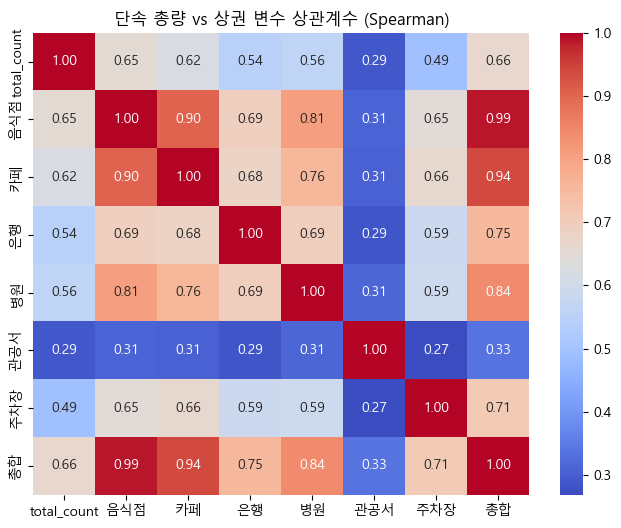

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_cols = ["total_count", "음식점", "카페", "은행", "병원", "관공서", "주차장", "총합"]
corr = df_total[corr_cols].corr(method="spearman")  # 순위 상관 추천

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("단속 총량 vs 상권 변수 상관계수 (Spearman)")
plt.show()

1. 단속 총량 vs 상권 변수 해석해보기!

- 음식점(0.65), 카페(0.62), 총합(0.66) → 꽤 강한 양의 상관
👉 음식점·카페가 많을수록 단속도 많은 경향

- 병원(0.56), 은행(0.54), 주차장(0.49) → 중간 정도 양의 상관
👉 영향은 있지만 음식점·카페만큼 크지 않음

- 관공서(0.29) → 거의 약한 상관
👉 관공서 밀집 정도는 단속과 큰 관계 없음

2. 상권 변수들끼리

- 음식점-카페(0.90), 음식점-총합(0.99), 카페-총합(0.94) → 상관이 매우 높음
👉 당연히 음식점·카페가 총합에 큰 비중 차지

- 이 때문에 회귀분석 시 다중공선성(multicollinearity) 문제 발생 가능성 있음

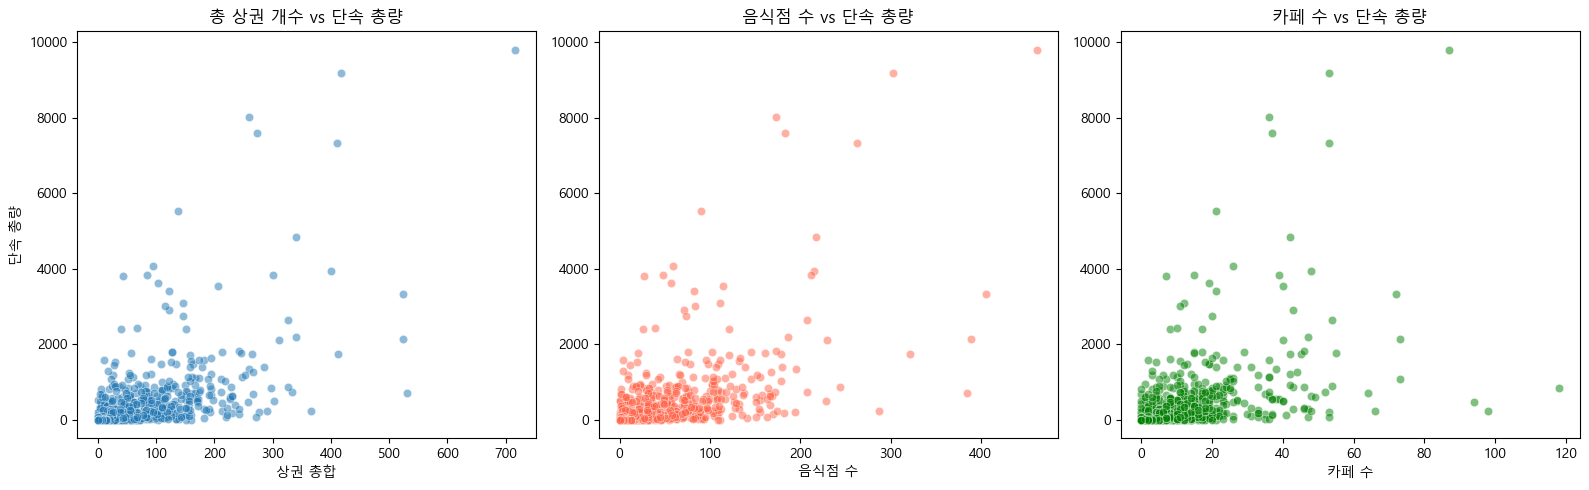

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16,5))

# 1. 총합
plt.subplot(1,3,1)
sns.scatterplot(data=df_total, x="총합", y="total_count", alpha=0.5)
plt.title("총 상권 개수 vs 단속 총량")
plt.xlabel("상권 총합")
plt.ylabel("단속 총량")

# 2. 음식점
plt.subplot(1,3,2)
sns.scatterplot(data=df_total, x="음식점", y="total_count", alpha=0.5, color="tomato")
plt.title("음식점 수 vs 단속 총량")
plt.xlabel("음식점 수")
plt.ylabel("")

# 3. 카페
plt.subplot(1,3,3)
sns.scatterplot(data=df_total, x="카페", y="total_count", alpha=0.5, color="green")
plt.title("카페 수 vs 단속 총량")
plt.xlabel("카페 수")
plt.ylabel("")

plt.tight_layout()
plt.show()

### 2. df_hour: 상권의 종류, 단속 시간에 따라서 단속 수가 많아지는가

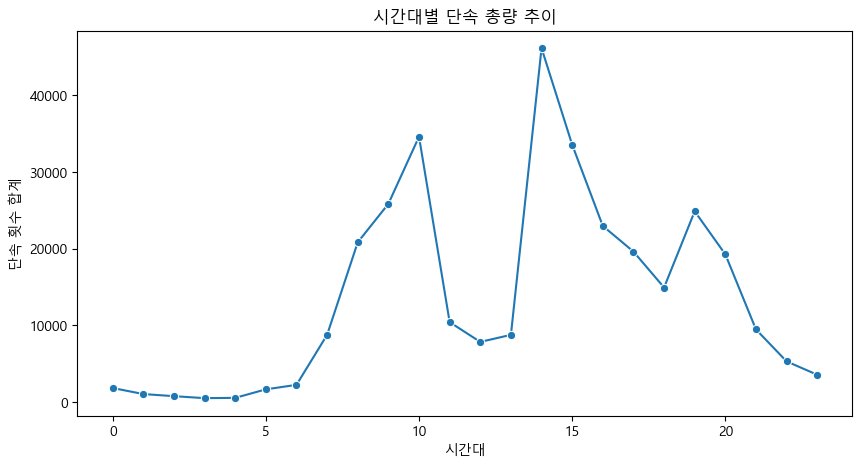

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,5))
sns.lineplot(data=df_hour.groupby("hour", as_index=False)["hourly_count"].sum(),
             x="hour", y="hourly_count", marker="o")
plt.title("시간대별 단속 총량 추이")
plt.xlabel("시간대")
plt.ylabel("단속 횟수 합계")
plt.show()

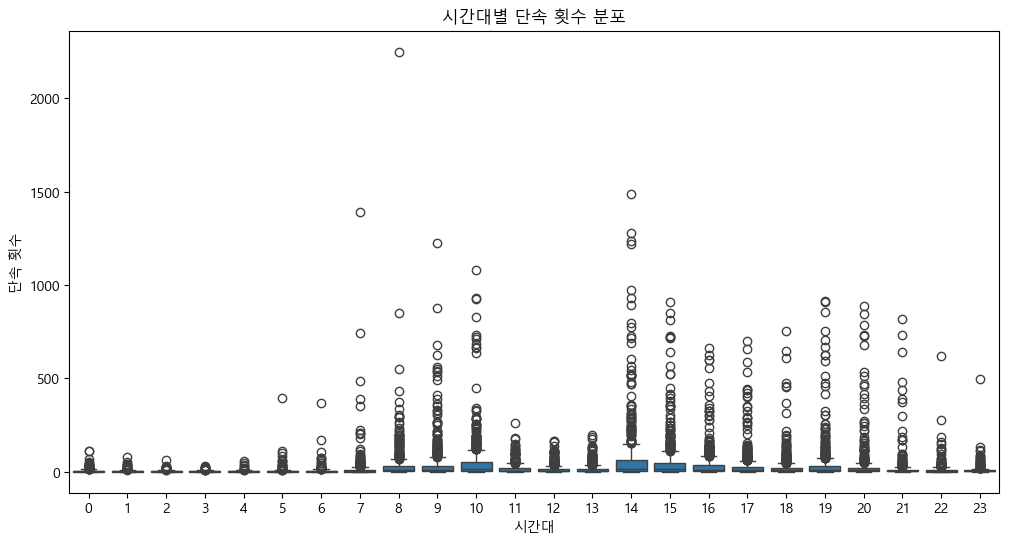

In [39]:
plt.figure(figsize=(12,6))
sns.boxplot(data=df_hour, x="hour", y="hourly_count")
plt.title("시간대별 단속 횟수 분포")
plt.xlabel("시간대")
plt.ylabel("단속 횟수")
plt.show()

In [41]:
for h in sorted(df_hour["hour"].unique()):
    sub = df_hour[df_hour["hour"]==h]
    if len(sub) > 5:  # 표본 너무 적으면 스킵
        corr = sub[["hourly_count","음식점","카페","은행","병원","관공서","주차장","총합"]].corr(method="spearman")
        print(f"\n시간대 {h}시 상관계수:")
        print(corr["hourly_count"].sort_values(ascending=False))


시간대 0시 상관계수:
hourly_count    1.000000
음식점             0.299958
총합              0.278137
은행              0.224545
카페              0.209181
병원              0.175810
주차장             0.137060
관공서             0.089403
Name: hourly_count, dtype: float64

시간대 1시 상관계수:
hourly_count    1.000000
음식점             0.200729
총합              0.190496
주차장             0.167231
카페              0.160809
병원              0.159254
은행              0.147776
관공서             0.064677
Name: hourly_count, dtype: float64

시간대 2시 상관계수:
hourly_count    1.000000
음식점             0.383348
총합              0.363954
카페              0.311000
은행              0.280512
주차장             0.234715
병원              0.213301
관공서            -0.063173
Name: hourly_count, dtype: float64

시간대 3시 상관계수:
hourly_count    1.000000
병원              0.255415
주차장             0.247239
음식점             0.239330
총합              0.237444
은행              0.212017
카페              0.203561
관공서            -0.015941
Name: hourly_count, dtype: float64

시간대

### 3. 정량적 분석(poisson, negative binomial 활용) 앞에서는 EDA를 한 것

In [43]:
#poisson 회귀
import statsmodels.api as sm

# --- 독립변수(X), 종속변수(y) ---
X = df_total[["음식점","카페","은행","병원","관공서","주차장"]]  # 총합은 음식점/카페랑 다중공선성 높아서 제외
X = sm.add_constant(X)  # 절편 추가
y = df_total["total_count"]

# --- Poisson 회귀 적합 ---
pois_model = sm.GLM(y, X, family=sm.families.Poisson()).fit()
print(pois_model.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:            total_count   No. Observations:                  889
Model:                            GLM   Df Residuals:                      882
Model Family:                 Poisson   Df Model:                            6
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -2.1393e+05
Date:                Fri, 22 Aug 2025   Deviance:                   4.2250e+05
Time:                        21:50:53   Pearson chi2:                 6.74e+05
No. Iterations:                     6   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.0435      0.003   1753.727      0.0

위에 데이터 해서기 coef-> ex) 관공서 1개 늘면 단속 횟수가 약 10.6% 증가, + 단위 증가 효과는 작지만, 음식점·카페는 개수가 많기 때문에 실제 총 효과는 커질 수 있음
p-value가 0.000 인것을 보아 통계적으로 유의미함

In [48]:
### 2단계 Poisson 모델의 과산포(overdispersion) 여부를 확인
#포아송은 분산= 평균 임을 가정하고 진행하지만 분산>> 평균이라면 nevigation binomial 회귀를 도입해야한다고 함
mean_y = y.mean()
var_y  = y.var()

print("평균:", mean_y)
print("분산:", var_y)
print("분산 / 평균 =", var_y / mean_y)

평균: 366.037120359955
분산: 735020.8758727793
분산 / 평균 = 2008.0500992630791


In [50]:
### 3단계 nevigation binomial 회귀
import statsmodels.api as sm

# 독립변수(X), 종속변수(y)
X = df_total[["음식점","카페","은행","병원","관공서","주차장"]]
X = sm.add_constant(X)
y = df_total["total_count"]

# Negative Binomial GLM
nb_model = sm.GLM(y, X, family=sm.families.NegativeBinomial()).fit()
print(nb_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:            total_count   No. Observations:                  889
Model:                            GLM   Df Residuals:                      882
Model Family:        NegativeBinomial   Df Model:                            6
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -5708.9
Date:                Fri, 22 Aug 2025   Deviance:                       2138.1
Time:                        21:59:08   Pearson chi2:                 2.92e+03
No. Iterations:                    17   Pseudo R-squ. (CS):             0.6189
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.4909      0.048     94.493      0.0

C:\Users\somin\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


1. 유의미한 변수들 (p<0.05)

음식점, 카페, 은행, 관공서, 주차장

→ 상권과 단속 증가가 확실히 연결

2. 가장 영향 큰 요인

관공서 (12.8%)

은행 (8.7%)
👉 관공서·은행 밀집 지역은 단속 집중이 강하다.

3. 중간 영향

주차장 (3.6%)

음식점 (0.9%), 카페 (1.4%) → 개수 자체가 많으니 누적효과는 클 수 있음.

4.무의미한 변수

병원 (p=0.489) → 단속 횟수와 통계적으로 관련 없음.

In [53]:
### 4_1단계 시간대를 연속형으로 반영
import statsmodels.api as sm
import pandas as pd

# --- 독립변수(X), 종속변수(y) ---
Xh = df_hour[["음식점","카페","은행","병원","관공서","주차장","hour"]]
Xh = sm.add_constant(Xh)  # 절편
yh = df_hour["hourly_count"]

# --- Negative Binomial GLM ---
nb_hour_model = sm.GLM(yh, Xh, family=sm.families.NegativeBinomial()).fit()
print(nb_hour_model.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:           hourly_count   No. Observations:                11059
Model:                            GLM   Df Residuals:                    11051
Model Family:        NegativeBinomial   Df Model:                            7
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -45897.
Date:                Fri, 22 Aug 2025   Deviance:                       22514.
Time:                        22:06:30   Pearson chi2:                 6.74e+04
No. Iterations:                    15   Pseudo R-squ. (CS):             0.3916
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.1600      0.027     79.645      0.0

C:\Users\somin\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


변수	계수(β)	exp(β)	해석
const	2.16	exp(2.16) ≈ 8.67	상권=0, hour=0일 때 baseline (실제 해석 의미 적음)
음식점	0.0028	1.003	음식점 1개 늘면 단속 횟수 0.3% 증가
카페	0.0080	1.008	카페 1개 늘면 단속 횟수 0.8% 증가
은행	0.0575	1.059	은행 1개 늘면 단속 횟수 5.9% 증가
병원	-0.0028	0.997	병원 1개 늘면 단속 횟수 0.3% 감소 (p=0.048 → 경계선 유의)
관공서	0.0197	1.020	관공서 1개 늘면 단속 횟수 2.0% 증가 (p=0.084 → 유의하지 않음)
주차장	0.0424	1.043	주차장 1개 늘면 단속 횟수 4.3% 증가
hour	0.0226	1.023	시간이 1시간 늦어질수록 단속 횟수 2.3% 증가

In [1]:
import pandas as pd

df_total = pd.read_csv("df_total.csv")
df_hour = pd. read_csv("df_hour.csv")

In [5]:
# 존재/타입 보장: 누락된 필드 있으면 에러
missing_required = [c for c in [TARGET] + BASE_COLS if c not in df_hour.columns]
if missing_required:
    raise KeyError(f"df_hour에 필요한 컬럼이 없습니다: {missing_required}")

# -----------------------------
# 2) hour를 범주형 더미로 변환
# -----------------------------
dfh = pd.get_dummies(df_hour, columns=["hour"], drop_first=True)

# 설계행렬 컬럼 구성
hour_cols = [c for c in dfh.columns if c.startswith("hour_")]
X_cols = ["음식점","카페","은행","병원","관공서","주차장"] + hour_cols

# -----------------------------
# 3) 숫자형 강제 변환 + 결측 처리
# -----------------------------
Xh = dfh[X_cols].apply(pd.to_numeric, errors="coerce")
yh = pd.to_numeric(dfh[TARGET], errors="coerce")

print("\n=== [더미 생성 후 타입] ===")
print(pd.Series({**{c:str(Xh[c].dtype) for c in Xh.columns}, TARGET:str(yh.dtype)}))

print("\n=== [더미 생성 후 결측 개수] ===")
print(pd.Series({**{c:int(Xh[c].isna().sum()) for c in Xh.columns}, TARGET:int(yh.isna().sum())}))

# 결측 채우기(설계행렬은 0, 타깃은 0으로 안전 처리)
Xh = Xh.fillna(0.0).astype(float)
yh = yh.fillna(0.0).astype(float)

# 음수/비정상 값 방지 (hourly_count는 카운트)
if (yh < 0).any():
    raise ValueError("hourly_count에 음수가 포함되어 있습니다.")

# 상수항 추가
Xh = sm.add_constant(Xh, has_constant="add")

# 최종 object 잔존 체크
if (Xh.dtypes == "object").any() or yh.dtype == "O":
    raise TypeError("object dtype이 남아있습니다. 전처리를 다시 확인하세요.")

# -----------------------------
# 4) Negative Binomial (GLM) 적합
#   - GLM의 NB는 alpha 기본=1 경고 표시 가능
# -----------------------------
print("\n=== [GLM Negative Binomial 적합] ===")
nb_glm = sm.GLM(yh, Xh, family=sm.families.NegativeBinomial()).fit()
print(nb_glm.summary())

# exp(계수) = 증가배수(incident rate ratio)
glm_params = nb_glm.params.copy()
glm_irrs = glm_params.apply(np.exp)
print("\n[GLM] exp(coef) (Incident Rate Ratios):")
print(glm_irrs.sort_values(ascending=False).round(3))

# -----------------------------
# 5) Negative Binomial (Discrete) 적합 + alpha 추정
#   - 분산모수 alpha를 함께 추정하고 싶을 때
# -----------------------------
print("\n=== [Discrete Negative Binomial 적합 (alpha 추정)] ===")
# 주의: 일부 statsmodels 버전에서 상수항 컬럼명이 'const'여야 안정적
if "const" not in Xh.columns:
    Xh = Xh.rename(columns={Xh.columns[0]:"const"})
nb_dm = NB_Discrete(yh, Xh).fit(disp=False)
print(nb_dm.summary())

dm_params = nb_dm.params.copy()
dm_irrs = dm_params.apply(np.exp)
alpha_est = nb_dm.params.get("alpha", np.nan)

print("\n[Discrete NB] exp(coef) (Incident Rate Ratios):")
print(dm_irrs.sort_values(ascending=False).round(3))
print(f"\n추정 alpha (분산 모수): {alpha_est:.4f}" if np.isfinite(alpha_est) else "\n추정 alpha: N/A")

# -----------------------------
# 6) 간단 해석 도움 출력
# -----------------------------
def pretty_effect(name, beta):
    irr = np.exp(beta)
    pct = (irr - 1.0) * 100
    return f"{name:15s}: β={beta:+.4f} → IRR={irr:.3f} (≈ {pct:+.1f}% 변화 / 단위증가)"

print("\n=== 주요 상권 변수 효과 (Discrete NB 기준) ===")
for name in ["음식점","카페","은행","병원","관공서","주차장"]:
    if name in dm_params.index:
        print(pretty_effect(name, dm_params[name]))


=== [더미 생성 후 타입] ===
음식점             int64
카페              int64
은행              int64
병원              int64
관공서             int64
주차장             int64
hour_1           bool
hour_2           bool
hour_3           bool
hour_4           bool
hour_5           bool
hour_6           bool
hour_7           bool
hour_8           bool
hour_9           bool
hour_10          bool
hour_11          bool
hour_12          bool
hour_13          bool
hour_14          bool
hour_15          bool
hour_16          bool
hour_17          bool
hour_18          bool
hour_19          bool
hour_20          bool
hour_21          bool
hour_22          bool
hour_23          bool
hourly_count    int64
dtype: object

=== [더미 생성 후 결측 개수] ===
음식점             0
카페              0
은행              0
병원              0
관공서             0
주차장             0
hour_1          0
hour_2          0
hour_3          0
hour_4          0
hour_5          0
hour_6          0
hour_7          0
hour_8          0
hour_9          0
hour_10  

C:\Users\somin\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


                 Generalized Linear Model Regression Results                  
Dep. Variable:           hourly_count   No. Observations:                11059
Model:                            GLM   Df Residuals:                    11029
Model Family:        NegativeBinomial   Df Model:                           29
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -43780.
Date:                Sun, 24 Aug 2025   Deviance:                       18280.
Time:                        16:27:15   Pearson chi2:                 5.01e+04
No. Iterations:                    13   Pseudo R-squ. (CS):             0.5851
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0434      0.066     15.766      0.0

C:\Users\somin\anaconda3\Lib\site-packages\statsmodels\discrete\discrete_model.py:3379: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
C:\Users\somin\anaconda3\Lib\site-packages\statsmodels\discrete\discrete_model.py:3379: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
C:\Users\somin\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                     NegativeBinomial Regression Results                      
Dep. Variable:           hourly_count   No. Observations:                11059
Model:               NegativeBinomial   Df Residuals:                    11029
Method:                           MLE   Df Model:                           29
Date:                Sun, 24 Aug 2025   Pseudo R-squ.:                 0.05907
Time:                        16:27:16   Log-Likelihood:                -43185.
converged:                      False   LL-Null:                       -45896.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8858      0.075     11.835      0.000       0.739       1.033
음식점            0.0056      0.000     13.015      0.000       0.005       0.006
카페             0.0036      0.002      2.300      0.0

- 상권 요인

은행, 주차장이 특히 강하게 단속을 불러옴.

음식점·카페는 개수당 영향은 작지만 많기 때문에 누적 효과가 큼.

병원은 주차 허용·배려 공간 영향인지 오히려 단속이 줄어듦

In [7]:
## 다중공산성 체크해보기-> 두개 제거하고 
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 설계행렬(X) 준비 (hour 포함 여부는 상황에 따라 다름)
X = df_total[["음식점","카페","은행","병원","관공서","주차장"]]
X = sm.add_constant(X)

# VIF 계산
vif_df = pd.DataFrame()
vif_df["변수"] = X.columns
vif_df["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_df)

      변수       VIF
0  const  1.993205
1    음식점  4.629841
2     카페  3.480564
3     은행  2.497196
4     병원  2.556554
5    관공서  1.046623
6    주차장  2.552518


VIF < 5 → 다중공선성 문제 거의 없음

5 ≤ VIF < 10 → 주의 필요

VIF ≥ 10 → 심각한 다중공선성